<center><h1> Projeto de Machine Learning </h1><center>
<center><h1>Previsão de Chuvas na Austrália</h1><center>

------------------------------------------------
<center>Eduardo Selber, Henrique Badin e Luca Caruso<center>

## Preparando o ambiente

In [231]:
#Importando as bibliotecas
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sweetviz as sv
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
#Carregando o dataset
dataframe = pd.read_csv("weatherAUS.csv")
df = dataframe.copy()

In [232]:
# #Gerando um relatorio de analise exploratoria
# report = sv.analyze(df)
# report.show_notebook()
print(df.columns)

for col in df.columns:
    print(f"{col}: {(df[col].isnull().sum()/df.shape[0])*100:.2f}%")

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')
Date: 0.00%
Location: 0.00%
MinTemp: 1.02%
MaxTemp: 0.87%
Rainfall: 2.24%
Evaporation: 43.17%
Sunshine: 48.01%
WindGustDir: 7.10%
WindGustSpeed: 7.06%
WindDir9am: 7.26%
WindDir3pm: 2.91%
WindSpeed9am: 1.21%
WindSpeed3pm: 2.11%
Humidity9am: 1.82%
Humidity3pm: 3.10%
Pressure9am: 10.36%
Pressure3pm: 10.33%
Cloud9am: 38.42%
Cloud3pm: 40.81%
Temp9am: 1.21%
Temp3pm: 2.48%
RainToday: 2.24%
RainTomorrow: 2.25%


## Data Wrangling
Primeiro vamos formatar os dados da base de dados para prepará-lo para o modelo preditivo

In [233]:
direcoes = {
    'W': (-1, 0),
    'SE': (0.7071, -0.7071),
    'N': (0, 1),
    'SSE': (0.7071, 0.7071),
    'E': (0, 1),
    'S': (-1, 0),
    'WSW': (-0.7071, 0.7071),
    'SW': (-0.7071, -0.7071),
    'SSW': (-0.9239, -0.3827),
    'WNW': (0.9239, -0.3827),
    'NW': (0.7071, -0.7071),
    'ENE': (0.3827, 0.9239),
    'ESE': (-0.3827, 0.9239),
    'NE': (0.7071, 0.7071),
    'NNW': (0.9239, 0.3827),
    'NNE': (0.9239, 0.3827)
}

df[['Cosseno_WindGustDir', 'Seno_WindGustDir']] = df['WindGustDir'].map(direcoes).apply(pd.Series)
df.drop('WindGustDir', axis=1, inplace=True)

df[['Cosseno_WindDir9am', 'Seno_WindDir9am']] = df['WindDir9am'].map(direcoes).apply(pd.Series)
df.drop('WindDir9am', axis=1, inplace=True)

df[['Cosseno_WindDir3pm', 'Seno_WindDir3pm']] = df['WindDir3pm'].map(direcoes).apply(pd.Series)
df.drop('WindDir3pm', axis=1, inplace=True)

df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,...,Temp9am,Temp3pm,RainToday,RainTomorrow,Cosseno_WindGustDir,Seno_WindGustDir,Cosseno_WindDir9am,Seno_WindDir9am,Cosseno_WindDir3pm,Seno_WindDir3pm
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,44.0,20.0,24.0,...,16.9,21.8,No,No,-1.0000,0.0000,-1.0000,0.0000,0.9239,-0.3827
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,44.0,4.0,22.0,...,17.2,24.3,No,No,0.9239,-0.3827,0.9239,0.3827,-0.7071,0.7071
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,46.0,19.0,26.0,...,21.0,23.2,No,No,-0.7071,0.7071,-1.0000,0.0000,-0.7071,0.7071
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,24.0,11.0,9.0,...,18.1,26.5,No,No,0.7071,0.7071,0.7071,-0.7071,0.0000,1.0000
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,41.0,7.0,20.0,...,17.8,29.7,No,No,-1.0000,0.0000,0.3827,0.9239,0.7071,-0.7071


In [234]:
df.RainToday.value_counts()

RainToday
No     110319
Yes     31880
Name: count, dtype: int64

In [235]:
df_today = df.copy()

In [236]:
df_today['RainTodayBinary'] = df['RainToday'].map({'Yes': 1, 'No': 0})
df_today.drop('RainToday', axis=1, inplace=True)

In [237]:
df_today.RainTodayBinary.value_counts()

RainTodayBinary
0.0    110319
1.0     31880
Name: count, dtype: int64

In [239]:
#Tratamento de valores ausentes: Deletando as linhas com os valores ausentes das colunas "Raintoday" e "RainTomorrow"
df_today = df_today.dropna(subset=["RainTomorrow"])

#Deixando apenas as colunas Date, Location, MinTemp, MaxTemp, Humidity9am, Humidity3pm, Pressure9am, Pressure3pm, Temp9am, Temp3pm, RainToday, RainTomorrow
df_today = df_today[["Date", "Location", "MinTemp", "MaxTemp", "Humidity9am", "Humidity3pm", "Pressure9am", "Pressure3pm", "Rainfall","Temp9am", "Temp3pm", "Cosseno_WindGustDir", "Seno_WindGustDir", "Cosseno_WindDir9am", "Seno_WindDir9am", "Cosseno_WindDir3pm", "Seno_WindDir3pm", "RainTodayBinary", "RainTomorrow"]]
df_today = df_today.dropna()

# #Tratamento dos outliers e features engineering:
#MinTemp
# df = df[(df["MinTemp"] >= -10) & (df["MinTemp"] <= 30)]

# #MaxTemp
# df = df[(df["MaxTemp"] >= 5) & (df["MaxTemp"] <= 40)]

# #Humidity9am não possui outliers
# #Humidity3pm não possui outliers

# #Pressure9am
# df = df[(df["Pressure9am"] >= 1000) & (df["Pressure9am"] <= 1035)]

# #Pressure3pm
# df = df[(df["Pressure3pm"] >= 1000) & (df["Pressure3pm"] <= 1035)]

# #Temp9am
# df = df[(df["Temp9am"] >= 5) & (df["Temp9am"] <= 30)]

# #Temp3pm
# df = df[(df["Temp3pm"] >= 8) & (df["Temp3pm"] <= 35)]

# df = df[(df["Rainfall"] >= 0) & (df["Rainfall"] <= 1)]

#Tratamento de variaveis categoricas 
#df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})

## EDA - Exploratory Data Analysis
Primeiro vamos analisar os dados que são fornecidos pela base de dados

### Colunas do dataset
- **Date** - A data da observação (formato: yyyy-mm-dd)
- **Location** - A localização da estação meteorológica (Nome da cidade - string)
- **MinTemp** - A temperatura mínima em graus Celsius (float)
- **MaxTemp** - A temperatura máxima em graus Celsius  (float)
- **Rainfall** - A quantidade de chuva medida em mm (float)
- **Evaporation** - A taxa de evaporação medida em mm (float)
- **Sunshine** - O número de horas de sol (float)
- **WindGustDir** - A direção da rajada de vento mais forte (string)
- **WindGustSpeed** - A velocidade (em km/h) da rajada de vento mais forte (float)
- **WindDir9am** - A direção do vento às 9am (string)
- **WindDir3pm** - A direção do vento às 3pm (string)
- **WindSpeed9am** - A velocidade do vento às 9am (em km/h) (float)
- **WindSpeed3pm** - A velocidade do vento às 3pm (em km/h) (float)
- **Humidity9am** - A umidade relativa às 9am (em %) (float)
- **Humidity3pm** - A umidade relativa às 3pm (em %) (float)
- **Pressure9am** - A pressão atmosférica reduzida ao nível do mar às 9am (em hpa) (float)
- **Pressure3pm** - A pressão atmosférica reduzida ao nível do mar às 3pm (em hpa) (float)
- **Cloud9am** - A fração de cobertura de nuvens às 9am (em oitavos) (float)
- **Cloud3pm** - A fração de cobertura de nuvens às 3pm (em oitavos) (float)
- **Temp9am** - A temperatura às 9am em graus Celsius (float)
- **Temp3pm** - A temperatura às 3pm em graus Celsius (float)
- **RainToday** - Se choveu (precipitação acima de 1mm) ou não (string)
- **RainTomorrow** - A variável alvo. Se choverá ou não amanhã (string)


In [240]:
df_today.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112925 entries, 0 to 145458
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Date                 112925 non-null  object 
 1   Location             112925 non-null  object 
 2   MinTemp              112925 non-null  float64
 3   MaxTemp              112925 non-null  float64
 4   Humidity9am          112925 non-null  float64
 5   Humidity3pm          112925 non-null  float64
 6   Pressure9am          112925 non-null  float64
 7   Pressure3pm          112925 non-null  float64
 8   Rainfall             112925 non-null  float64
 9   Temp9am              112925 non-null  float64
 10  Temp3pm              112925 non-null  float64
 11  Cosseno_WindGustDir  112925 non-null  float64
 12  Seno_WindGustDir     112925 non-null  float64
 13  Cosseno_WindDir9am   112925 non-null  float64
 14  Seno_WindDir9am      112925 non-null  float64
 15  Cosseno_WindDir3pm   1

In [242]:
df_today.RainTodayBinary.value_counts()

RainTodayBinary
0.0    87556
1.0    25369
Name: count, dtype: int64

In [243]:
# Verificando as métricas do dataset
df_today.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MinTemp,112925.0,12.664721,6.254135,-8.2000,8.1000,12.4000,17.2000,33.9000
MaxTemp,112925.0,23.655670,6.982702,2.6000,18.3000,23.1000,28.7000,48.1000
Humidity9am,112925.0,67.404162,18.911610,0.0000,56.0000,68.0000,81.0000,100.0000
Humidity3pm,112925.0,50.669055,20.768550,0.0000,36.0000,51.0000,65.0000,100.0000
Pressure9am,112925.0,1017.425847,7.032654,980.5000,1012.8000,1017.4000,1022.1000,1041.0000
Pressure3pm,112925.0,1015.048962,6.957822,977.1000,1010.3000,1015.0000,1019.7000,1039.6000
Rainfall,112925.0,2.377892,8.602968,0.0000,0.0000,0.0000,0.8000,367.6000
Temp9am,112925.0,17.462008,6.355045,-3.1000,12.7000,17.1000,22.0000,40.2000
Temp3pm,112925.0,22.127306,6.837380,1.7000,16.9000,21.6000,26.9000,46.7000
Cosseno_WindGustDir,112925.0,0.023528,0.734322,-1.0000,-0.7071,0.0000,0.7071,0.9239


VARIÁVEIS NUMÉRICAS


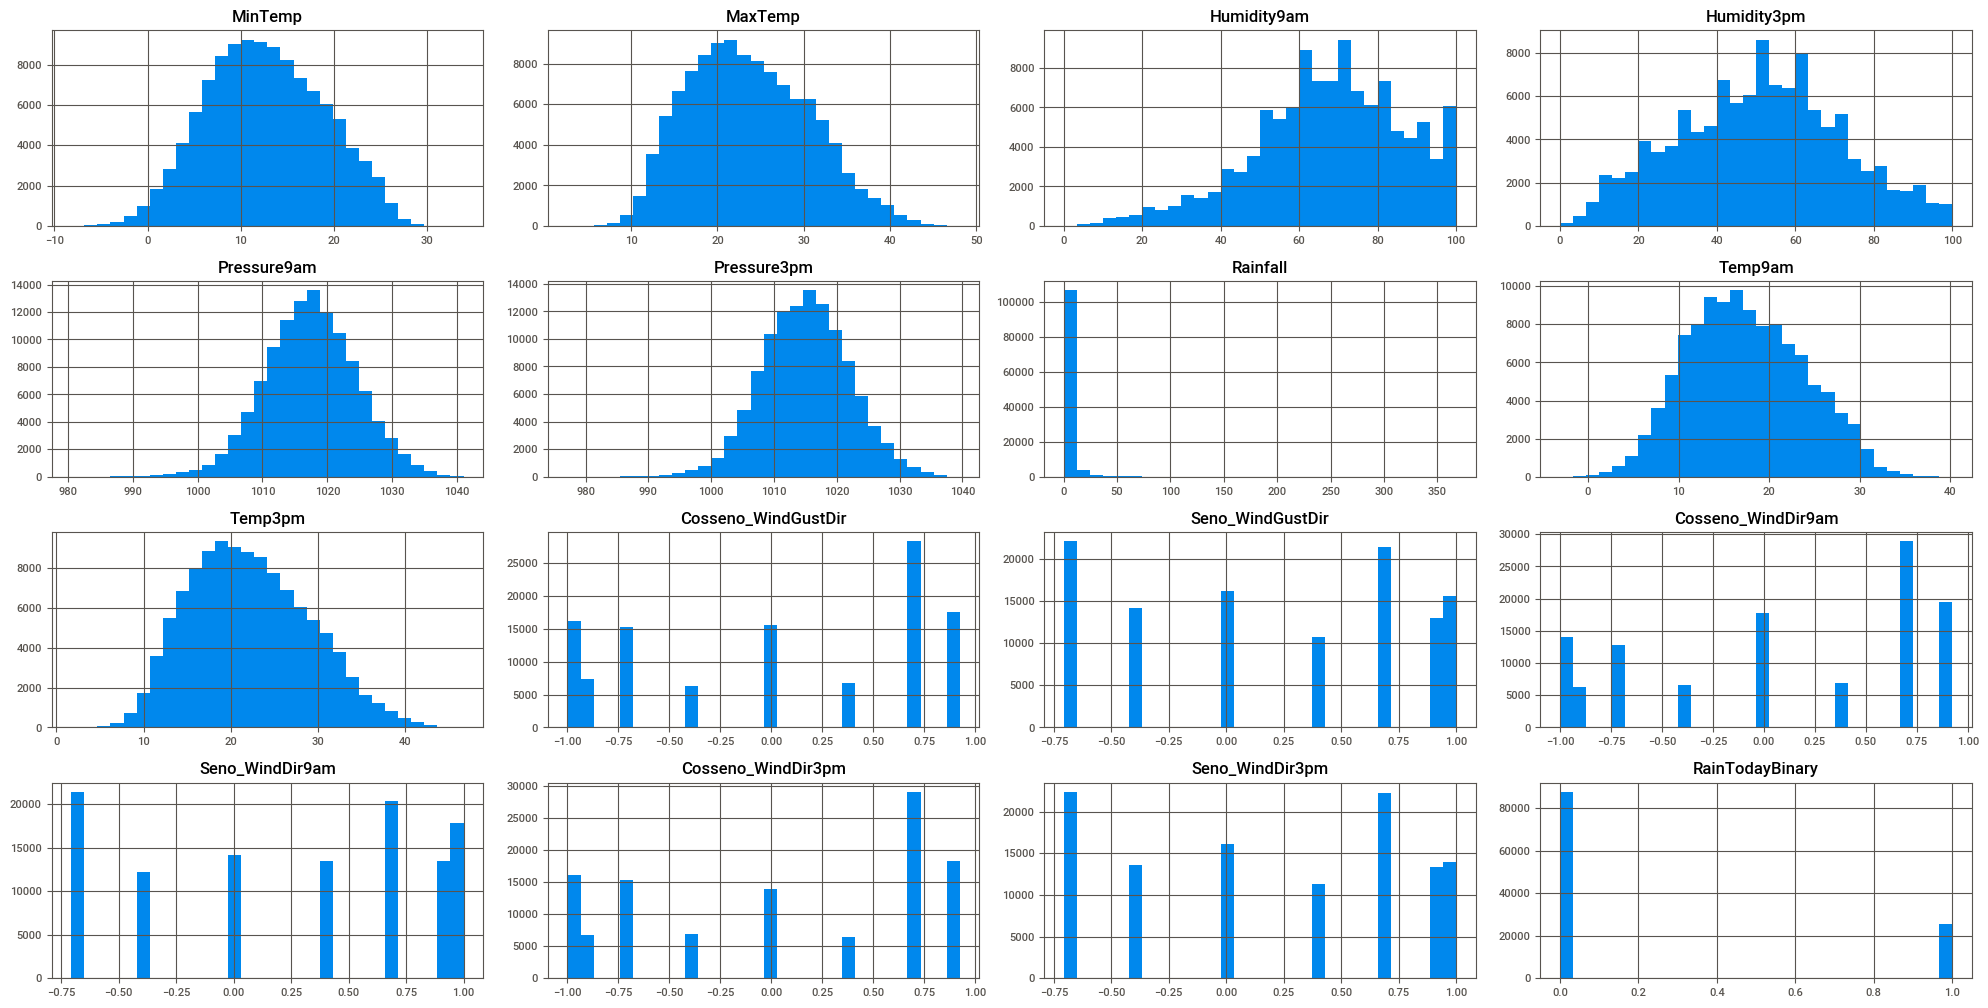

In [244]:
# Estatísticas descritivas do DataFrame
df_today.describe()

print("VARIÁVEIS NUMÉRICAS")
# Distribuição das variáveis numéricas
df_today.hist(bins=30, figsize=(20, 15), layout=(6, 4))
plt.tight_layout()
plt.show()

# print("VARIÁVEIS CATEGÓRICAS")
# # Contagem das variáveis categóricas do DataFrame
# plt.figure(figsize=(20, 15))
# for i, column in enumerate(df.select_dtypes(include='object').columns, 1):
#     plt.subplot(3, 3, i)
#     sns.countplot(data=df, y=column)
#     plt.title(f'{column} Count')
#     plt.xticks(rotation=45)

In [247]:
df_today.shape


(112925, 19)

In [248]:
df_today.head()

,Date,Location,MinTemp,MaxTemp,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Rainfall,Temp9am,Temp3pm,Cosseno_WindGustDir,Seno_WindGustDir,Cosseno_WindDir9am,Seno_WindDir9am,Cosseno_WindDir3pm,Seno_WindDir3pm,RainTodayBinary,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,71.0,22.0,1007.7,1007.1,0.6,16.9,21.8,-1.0000,0.0000,-1.0000,0.0000,0.9239,-0.3827,0.0,No
1,2008-12-02,Albury,7.4,25.1,44.0,25.0,1010.6,1007.8,0.0,17.2,24.3,0.9239,-0.3827,0.9239,0.3827,-0.7071,0.7071,0.0,No
2,2008-12-03,Albury,12.9,25.7,38.0,30.0,1007.6,1008.7,0.0,21.0,23.2,-0.7071,0.7071,-1.0000,0.0000,-0.7071,0.7071,0.0,No
3,2008-12-04,Albury,9.2,28.0,45.0,16.0,1017.6,1012.8,0.0,18.1,26.5,0.7071,0.7071,0.7071,-0.7071,0.0000,1.0000,0.0,No
4,2008-12-05,Albury,17.5,32.3,82.0,33.0,1010.8,1006.0,1.0,17.8,29.7,-1.0000,0.0000,0.3827,0.9239,0.7071,-0.7071,0.0,No


In [249]:
#Filtrando o dataset para a cidade de Sydney
df_today = df_today[df_today["Location"] == "Sydney"]

#Ordenando o dataset pela coluna Date
df_today = df_today.sort_values("Date")

In [250]:
#Dividindo o dataset em train test e validação
#Treinamento: 60%
#Teste: 20%
#Validação: 20%

#quantidade de linhas do dataset
n_lines = df_today.shape[0]

#separando o dataset em treinamento, teste e validação
train = df_today[0:int(n_lines*0.6)]
validation = df_today[int(n_lines*0.6):int(n_lines*0.8)]
test = df_today[int(n_lines*0.8):]


In [251]:
def make_x_y(df):
    df = df.drop(["Date", "Location"], axis=1)
    x = df.drop("RainTomorrow", axis=1).copy()
    y = df["RainTomorrow"].copy()
    return x, y
x_train, y_train = make_x_y(train)
x_validation, y_validation = make_x_y(validation)
x_test, y_test = make_x_y(test)

In [252]:
def make_windows(x, y, columns_orig, window_size):
    x_window = []
    y_window = []
    for i in range(len(x)-window_size-1):
        x_window.append(x[i:i+window_size].reshape(-1))
        y_window.append(y[i+window_size])

    columns = []
    for i in range(window_size):
        for column in columns_orig:
            columns.append(f"{column}_{i}")
    return np.array(x_window), np.array(y_window), columns

window = 1
columns_orig = train.columns[2:-1]
x_train, y_train, columns = make_windows(x_train.values, y_train.values, columns_orig, window)
x_validation, y_validation, _ = make_windows(x_validation.values, y_validation.values, columns_orig, window)

In [253]:
pd.Series(y_validation).value_counts(normalize=True)

No     0.735556
Yes    0.264444
Name: proportion, dtype: float64

In [254]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Definindo os parâmetros para a busca
parametros = {
    'model__n_estimators': [100, 200, 300, 400, 500, 1000],         # Número de árvores
    'model__max_depth': [None, 5, 7, 10, 20, 30],           # Profundidade máxima das árvores
}

# Criar o modelo RandomForest
rf = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=5)

# Construir o pipeline
pipeline = Pipeline([
    ("scaler", StandardScaler()),  # Escalonar as features
    ("model", rf)                   # RandomForest
])

# Usar GridSearchCV para encontrar os melhores parâmetros
grid_search = GridSearchCV(pipeline, parametros, cv=3, n_jobs=-1, verbose=2, scoring="accuracy")

# Ajustar o modelo com o GridSearchCV
grid_search.fit(x_train, y_train)

# Melhor combinação de parâmetros
print("Melhores parâmetros encontrados:", grid_search.best_params_)

# Avaliar o modelo com os melhores parâmetros no conjunto de validação
y_pred_val = grid_search.predict(x_validation)

# Exibir resultados
print("Matriz de Confusão:")
print(confusion_matrix(y_validation, y_pred_val))
print("\nRelatório de Classificação:")
print(classification_report(y_validation, y_pred_val))
print("\nAcurácia:", accuracy_score(y_validation, y_pred_val))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Melhores parâmetros encontrados: {'model__max_depth': 5, 'model__n_estimators': 100}
Matriz de Confusão:
[[325   6]
 [114   5]]

Relatório de Classificação:
              precision    recall  f1-score   support

          No       0.74      0.98      0.84       331
         Yes       0.45      0.04      0.08       119

    accuracy                           0.73       450
   macro avg       0.60      0.51      0.46       450
weighted avg       0.66      0.73      0.64       450


Acurácia: 0.7333333333333333


In [255]:
y_pred_val

array(['No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'N